In [3]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from RBFlib import RBF
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import unary_union
from simplification.cutil import simplify_coords_vw
import json
from itertools import combinations
import copy

In [29]:
import rosreestr2coord
import rosreestr2coord.console
import rosreestr2coord.export
# Создание объекта Area с кадастровым номером участка
area = rosreestr2coord.console.Area('23:01:0802000:1756')
rosreestr2coord.export.area_json_output('t.geojson',area=area)
# Преобразование данных в формат GeoJSON
area.to_geojson()

'{"id": 82677805, "type": "Feature", "geometry": {"type": "Polygon", "coordinates": [[[38.320908920265374, 44.804199031579394], [38.32070802704981, 44.80280195746109], [38.31983277608082, 44.80250353325786], [38.31963414218973, 44.800314300374694], [38.319327824543, 44.79875384778615], [38.31949042409535, 44.798351400547816], [38.320869090311646, 44.798251952110434], [38.321375050817906, 44.79927702148068], [38.32238788517998, 44.80166837840979], [38.32161516066009, 44.80180528747301], [38.321538840650156, 44.80345451255993], [38.320908920265374, 44.804199031579394]]], "crs": {"type": "name", "properties": {"name": "EPSG:3857"}}}, "properties": {"cadastralDistrictsCode": 23, "category": 36368, "categoryName": "\\u0417\\u0435\\u043c\\u0435\\u043b\\u044c\\u043d\\u044b\\u0435 \\u0443\\u0447\\u0430\\u0441\\u0442\\u043a\\u0438 \\u0415\\u0413\\u0420\\u041d", "descr": "23:01:0802000:1756", "externalKey": "23:01:0802000:1756", "interactionId": 82633792, "label": "23:01:0802000:1756", "options"

In [27]:
print(area)

In [4]:
def loocv(x, y, model):
    warnings.filterwarnings("ignore")
    """х - массив точек [x,y].
    у - массив значений.
    возвращаяет R2 LOOCV модели"""
    pred = []
    loo = LeaveOneOut()
    if type(x) is not np.array:
        x = np.array(x)
    if type(y) is not np.array:
        y = np.array(y)
    for i, (train_index, test_index) in enumerate(loo.split(x)):
        model.fit(x[train_index], y[train_index])
        res = model.predict(np.array(x[test_index]))
        pred.append(float(res))
    return r2_score(y, pred)

In [5]:
def normalize(mas, coef):
    """Возвращает нормализированный массив от 0 до 1, умноженный на коэффициент coef"""
    mas = np.array(mas)
    mas_min = mas.min()
    mas_max = mas.max()
    if mas_max - mas_min == 0:
        mas_norm = np.zeros_like(mas)
    else:
        mas_norm = coef * (mas - mas_min) / (mas_max - mas_min)
    return mas_norm


def denormalize(mas_norm, min, max, coef):
    """Возвращает ДЕнормализированный массив, mas_norm - нормализированный от 0 до 1 и умноженный на коэффициент coef"""
    mas_norm = np.array(mas_norm) / coef

    if max - min == 0:
        return np.full_like(mas_norm, min)
    else:
        mas_denorm = min + mas_norm * (max - min)
        return mas_denorm

In [6]:
def calc_surface(
    data: dict,
    coordinates: dict,
    borders=None,
    resolution=100,
    model=RBF(),
    validation=False,
    normalize=True,
    gap=10,
):
    """
    Выполняет пространственную интерполяцию значений по разреженным точечным данным
    и возвращает регулярную сетку для визуализации (например, тепловых карт или изолиний).

    Args:
        data (dict): Словарь вида {id: значение}, где значение — скалярная величина
            (например, высота, температура) в точке с идентификатором id.
        coordinates (dict): Словарь вида {id: (x, y)}, задающий 2D-координаты тех же точек.
        borders (shapely.geometry.Polygon, optional): Полигон, ограничивающий область
            интерполяции. Если не задан, границы определяются автоматически по экстенту точек.
        resolution (int, optional): Разрешение выходной сетки (количество узлов по каждой оси).
            По умолчанию 100.
        model (sklearn-compatible regressor, optional): Модель для интерполяции.
            По умолчанию используется RBF (радиально-базисная функция).
        validation (bool, optional): Если True, дополнительно вычисляется коэффициент
            детерминации R² с помощью leave-one-out кросс-валидации. По умолчанию False.
        normalize (bool, optional): Флаг нормализации координат (StandardScaler) перед обучением.
            По умолчанию True.
        gap (int, optional): Процент расширения области вокруг точек для формирования сетки
            (создаёт отступ). По умолчанию 10%.

    Returns:
        tuple: Кортеж из пяти элементов:
            - aa (np.ndarray): 2D-массив координат X (результат meshgrid).
            - bb (np.ndarray): 2D-массив координат Y (результат meshgrid).
            - z_map (np.ndarray): 2D-массив интерполированных значений Z.
            - borders (shapely.geometry.Polygon): Полигон, описывающий границы области
              интерполяции (либо заданный пользователем, либо автоматически сформированный).
            - r2_or_dash (float or str): Если validation=True — значение R²;
              иначе строка '-'.

    Notes:
        - Все ключи в `data` и `coordinates` должны совпадать.
        - При `normalize=True` координаты обучающей выборки и предикторной сетки нормализуются
          **независимо**, что может повлиять на интерполяцию при смещении масштабов.
        - Если `borders` не задан, создаётся прямоугольный полигон, охватывающий расширенный
          экстент точек с учётом параметра `gap`.
    """

    X = np.array(list(coordinates.values()))  # X- массив координат [[x1.y1].[x2.y2]...]

    x, y = X.T[0], X.T[1]  # координаты X и Y отдельно

    if borders != None:
        minx, miny, maxx, maxy = borders.bounds
        bounds_x = [minx, maxx]
        bounds_y = [miny, maxy]
    else:
        bounds_x = [min(x), max(x)]
        bounds_y = [min(y), max(y)]
    delta_x = (bounds_x[1] - bounds_x[0]) * gap / 100
    delta_y = (bounds_y[1] - bounds_y[0]) * gap / 100

    resolution = int(resolution)

    aa, bb = np.meshgrid(
        np.linspace(bounds_x[0] - delta_x, bounds_x[1] + delta_x, resolution),
        np.linspace(bounds_y[0] - delta_y, bounds_y[1] + delta_y, resolution),
    )

    if borders == None:
        borders = Polygon(
            [
                [aa.min(), bb.min()],
                [aa.min(), bb.max()],
                [aa.max(), bb.max()],
                [aa.max(), bb.min()],
            ]
        )

    xx = np.vstack([aa.ravel(), bb.ravel()]).T

    if normalize:
        scaler = StandardScaler()
        learn_X = scaler.fit_transform(np.array(list(coordinates.values())))
        pred_xx = scaler.fit_transform(xx)

    else:
        learn_X = X
        pred_xx = xx

    learn_Z = np.array(list(data.values())).reshape(-1, 1)  # массив значений
    model.fit(learn_X, learn_Z)
    z_map = model.predict(pred_xx).reshape(resolution, resolution)
    if validation:
        r2 = loocv(X, learn_Z, model)
        return aa, bb, z_map, borders, r2
    else:
        return aa, bb, z_map, borders, "-"

In [7]:
def create_map(xx, yy, zz, levels=10):
    """
    Генерирует список трёхмерных полигонов на основе заполненных изолиний (contourf).

    Функция строит карту изолиний по регулярной сетке значений и преобразует каждый
    замкнутый контур в трёхмерный полигон, где z-координата всех точек контура равна
    значению соответствующего уровня. Результат удобен для последующего экспорта
    (например, в GeoJSON с высотами) или 3D-визуализации.

    Args:
        xx (np.ndarray): 2D-массив координат X (обычно результат np.meshgrid).
        yy (np.ndarray): 2D-массив координат Y (обычно результат np.meshgrid).
        zz (np.ndarray): 2D-массив интерполированных или измеренных значений Z.
        levels (int or array-like, optional): количество уровней изолиний или явный
            список значений уровней. По умолчанию 10.

    Returns:
        list[np.ndarray]: список полигонов, каждый из которых представлен как массив
        формы (N, 3), где N — число вершин, а каждый ряд содержит координаты [x, y, z].
        Значение z одинаково для всех точек одного полигона и соответствует уровню
        изолинии, из которого он получен.

    Notes:
        - Функция корректно обрабатывает вырожденные значения уровня (например,
          ±inf или значения вроде ±1e200), заменяя их на ближайшие граничные
          значения из шкалы `countr.levels`.
        - Каждый отдельный сегмент (включая «дыры» или изолированные контуры)
          сохраняется как независимый полигон.
        - Внутренний вызов `plt.contourf` не отображает график: фигура сразу закрывается
          через `plt.close()`, чтобы избежать утечек памяти при массовом использовании.
    """

    countr = plt.contourf(xx, yy, zz, levels=levels)
    plt.close()


    polygons = []
    for i, level_segs in enumerate(countr.allsegs):

        z_val = float(countr.cvalues[i])
        # Замена "extend"-значений

        if z_val < -1e200:
            z_val = countr.levels[0]

        elif z_val > 1e200:
            z_val = countr.levels[-1]
        for seg in level_segs:

            seg_3d = np.column_stack([seg, np.full(len(seg), z_val)])

            polygons.append(seg_3d)


    return polygons

In [8]:
def polygon_area(poly_2d):
    """Возвращает площадь полигона (может быть 0 для вырожденных)."""
    try:
        return float(poly_2d.area)
    except Exception:
        return 0.0


def relative_tolerance(poly_2d, rel=0.01):
    """
    Возвращает tolerance для Visvalingam–Whyatt.
    rel — доля от площади самого полигона (не bbox!).
    """
    area = polygon_area(poly_2d)
    if area <= 0:
        # Если полигон вырожденный — используем bbox-площадь
        minx, miny, maxx, maxy = poly_2d.bounds
        area = (maxx - minx) * (maxy - miny) or 1e-16
    return area * rel

In [9]:
def simplify_polygons(polygons, z_values, tolerance=0.1):
    """
    Упрощает список трёхмерных полигонов, сохраняя их высоту (z-координату).

    Каждый полигон упрощается по алгоритму Visvalingam–Whyatt (VW) на основе его
    двумерной проекции (x, y), после чего к упрощённым координатам добавляется
    исходное значение z (одинаковое для всех точек полигона). Результат — список
    упрощённых замкнутых 3D-полигонов.

    Args:
        polygons (list[list[list[float]]]): Список полигонов, где каждый полигон —
            это список точек вида [[x1, y1, z1], [x2, y2, z2], ...].
            Предполагается, что все точки в пределах одного полигона имеют одинаковую z-координату.
        z_values (list[float]): Список значений z, соответствующих каждому полигону.
            Обычно берётся из первой точки каждого полигона.
        tolerance (float, optional): Порог упрощения для алгоритма VW.
            Чем выше значение — тем сильнее упрощение. По умолчанию 0.1.

    Returns:
        list[list[list[float]]]: Список упрощённых полигонов в том же формате,
        что и входные данные. Полигоны с менее чем 3 вершинами пропускаются.
        Каждый возвращаемый полигон гарантированно замкнут (первая и последняя точки совпадают),
        если содержит ≥3 вершин.

    Notes:
        - Для упрощения используется функция `simplify_coords_vw` из библиотеки `simplification`.
        - Исходные z-координаты игнорируются; вместо них используется значение из `z_values`.
        - Полигоны, у которых после упрощения остаётся менее 3 точек, отбрасываются.
    """

    simplified = []

    for poly, z in zip(polygons, z_values):
        if len(poly) < 3:
            continue  # пропускаем слишком короткие

        # Извлекаем только x, y
        xy = np.array(poly)[:, :2]  # берём первые два столбца

        # Упрощаем (алгоритм Visvalingam–Whyatt)
        xy_simpl = simplify_coords_vw(xy.tolist(), tolerance)

        # Добавляем обратно z (одинаковое для всех точек полигона)
        poly_simpl = [[x, y, z] for x, y in xy_simpl]

        # Убедимся, что полигон замкнут (опционально)
        if len(poly_simpl) >= 3 and poly_simpl[0] != poly_simpl[-1]:
            poly_simpl.append(poly_simpl[0])

        simplified.append(poly_simpl)
    return simplified

In [10]:
def clip_polygons(polygons_coords, boundary):
    """
    Визуализирует список трёхмерных полигонов на двумерной плоскости (по координатам x, y),
    раскрашивая их в зависимости от высоты (z-координаты).
    ------
    Args:
        polygons (list of list of [x, y, z]): список полигонов, каждый из которых задан как
            последовательность трёхмерных точек. Предполагается, что все точки в пределах
            одного полигона имеют одинаковое значение z (например, горизонтальные сечения).
        save_pic (bool, optional): если True, сохраняет изображение в файл 'map.png' без
            отображения окна. Если False (по умолчанию), отображает график интерактивно.

    Особенности:
        - Полигоны с менее чем тремя вершинами игнорируются.
        - Цвет каждого полигона определяется по его z-значению (берётся первая точка).
        - Используется цветовая карта 'viridis', чёрная тонкая граница и равный масштаб осей.
        - Добавляется цветовая шкала и лёгкая сетка.

    Примечание:
        Функция автоматически закрывает фигуру после отображения или сохранения,
        чтобы избежать утечек памяти при многократных вызовах.
    """

    clipped_polygons = []

    for coords in polygons_coords:
        poly = Polygon(coords)
        if not poly.is_valid:

            poly = poly.buffer(0)  # попытка исправить невалидную геометрию
        intersection = poly.intersection(boundary)
        if intersection.is_empty:
            continue

        if isinstance(intersection, Polygon):
            if not intersection.is_empty and intersection.exterior.coords:
                clipped_polygons.append(list(intersection.exterior.coords))

        elif isinstance(intersection, MultiPolygon):
            for part in intersection.geoms:
                if not part.is_empty and part.exterior.coords:
                    clipped_polygons.append(list(part.exterior.coords))

    return clipped_polygons

In [164]:
def plot_polygons(
    polygons,outer_contour=None,
    save_pic=False,
):

    """
    Визуализирует список трёхмерных полигонов на 2D-плоскости с цветовой кодировкой по высоте (z).

    Каждый полигон отображается как замкнутая фигура, раскрашенная в соответствии со значением
    его z-координаты (берётся из первой точки). Поддерживается сохранение изображения в файл
    или интерактивное отображение.

    Args:
        polygons (list[list[list[float]]]): Список полигонов, где каждый полигон —
            это список точек вида [[x1, y1, z1], [x2, y2, z2], ...].
            Все точки в пределах одного полигона должны иметь одинаковое значение z.
        save_pic (bool, optional): Если True — график сохраняется в файл `map.png`
            без отображения. Если False (по умолчанию) — график показывается в окне.

    Notes:
        - Полигоны с менее чем тремя вершинами игнорируются.
        - Используется цветовая карта `'viridis'`, чёрные тонкие границы и равный масштаб осей.
        - Добавляется цветовая шкала и лёгкая пунктирная сетка.
        - Фигура автоматически закрывается после отрисовки, чтобы избежать утечек памяти
          при многократных вызовах.
    """

    fig, ax = plt.subplots(figsize=(8, 8))
    patches = []

    z_values = []

    for coords in polygons:
        if len(coords) < 3:
            continue

        # Извлекаем x, y и z
        xy = [(x, y) for x, y, z in coords]

        z_vals = [z for x, y, z in coords]
        z_mean = z_vals[0]
        patches.append(MplPolygon(xy, closed=True))
        z_values.append(z_mean)


    if not patches:

        print("Нет валидных полигонов для отрисовки.")
        return

    # Создаём коллекцию и задаём цвета

    p = PatchCollection(
        patches, cmap="viridis", alpha=1, edgecolor="black", linewidth=0.5
    )
    p.set_array(np.array(z_values))
    ax.add_collection(p)

    if outer_contour is not None and len(outer_contour) >= 2:
        # Определяем, 2D или 3D
        first_point = outer_contour[0]
        if len(first_point) == 3:
            contour_xy = [(x, y) for x, y, z in outer_contour]
        elif len(first_point) == 2:
            contour_xy = [(x, y) for x, y in outer_contour]
        else:
            raise ValueError("Точки контура должны быть 2D или 3D.")

        # Замыкаем контур, если нужно
        if contour_xy[0] != contour_xy[-1]:
            contour_xy = contour_xy + [contour_xy[0]]

        xs, ys = zip(*contour_xy)
        ax.plot(xs, ys, color='red', linewidth=2, label='Outer Contour')

    ax.set_aspect("equal")
    ax.autoscale_view()

    plt.colorbar(p, ax=ax, shrink=0.8)

    plt.grid(True, linestyle=":", alpha=0.5)
    plt.tight_layout()
    if save_pic:

        plt.savefig("map.png")
    else:
        plt.show()
    plt.close()

In [12]:
def create_json_polygons(
    polygons, coef=0, tolerance=0.1, description="контур", postfix=""
):
    """
    Формирует список словарей в формате JSON для передачи или сохранения контурных полигонов.
    Каждый элемент списка представляет собой объект с идентификатором, названием,
    координатами полигона и описанием, содержащим соответствующее значение из списка `values`.
    Args:
        polygons (list of array-like): Список полигонов, где каждый полигон — это массив
            координат (обычно в формате [[x1, y1, z1], [x2, y2, z2], ...]).
        values (list of float): Список числовых значений, соответствующих каждому полигону.
            Используется в описании контура.
        description (str, optional): Базовое текстовое описание, вставляемое в поле
            "description". По умолчанию "контур".
        postfix (str, optional): Дополнительный суффикс (например, единица измерения),
            добавляемый к значению в описании. По умолчанию пустая строка.
    Returns:
        list of dict: Список словарей, каждый из которых содержит поля:
            - "id": уникальный идентификатор вида "contour-0", "contour-1", ...
            - "name": название вида "Контур 0", "Контур 1", ...
            - "coordinates": исходный массив координат полигона
            - "description": строка вида "{description} {value:.2f} {postfix}"
    """
    json_list = []
    z_orig = []
    for coords in polygons:
        z_orig.append(coords[0][2])
    if coef != 0:
        z_norm = normalize(z_orig, coef).tolist()
        polygons_norm = simplify_polygons(polygons, z_norm, tolerance)
    else:
        z_norm = z_orig
        polygons_norm = simplify_polygons(polygons, z_norm, tolerance)

    for i in range(len(polygons)):
        json_list.append(
            {
                "id": f"contour-{i}",
                "name": f"Контур {i}",
                "coordinates": list(polygons_norm[i]),
                "description": f"{description} {z_orig[i]:.2f} {postfix}",
            }
        )
    with open("output.json", "w", encoding="utf-8") as f:
        json.dump(json_list, f, ensure_ascii=False, indent=2)

    return json.dumps(json_list, ensure_ascii=False, indent=2)

In [13]:
def prepare_polygon(polygons, coef=0, tolerance=0.1):
    """
    Подготавливает список трёхмерных полигонов для последующего экспорта в формате GeoJSON:
    извлекает исходные высоты, при необходимости нормализует их, упрощает геометрию полигонов
    и преобразует координаты в двумерный формат.

    Параметры:
        polygons (list of list of [x, y, z]): список полигонов, каждый из которых представлен
            как список трёхмерных точек [x, y, z]. Предполагается, что все точки в пределах
            одного полигона имеют одинаковую z-координату (например, горизонтальные сечения).
        coef (float, optional): коэффициент нормализации высот. Если не равен нулю, исходные
            высоты (z_orig) нормализуются с использованием этого коэффициента. По умолчанию 0.
        tolerance (float, optional): допуск упрощения полигонов (в единицах координат).
            Передаётся в функцию simplify_polygons. По умолчанию 0.1.

    Возвращает:
        tuple: кортеж из трёх элементов:
            - polygons_2d (list of list of [x, y]): упрощённые полигоны в 2D-формате,
              замкнутые (первая и последняя точки совпадают);
            - z_orig (list of float): исходные значения z-координат (взяты из первой точки
              каждого полигона);
            - z_norm (list of float): нормализованные высоты (если coef != 0), иначе копия z_orig.

    Примечание:
        Функция гарантирует, что каждый 2D-полигон замкнут: если первая и последняя точки
        не совпадают, последняя точка дублируется в конец.
    """

    z_orig = []

    for coords in polygons:
        z_orig.append(coords[0][2])

    if coef != 0:
        z_norm = normalize(z_orig, coef).tolist()
        polygons_simple = simplify_polygons(polygons, z_norm, tolerance)
    else:
        z_norm = z_orig
        polygons_simple = simplify_polygons(polygons, z_norm, tolerance)


    polygons_2d = []
    for poly in polygons_simple:
        xy = [[x, y] for x, y, z in poly]
        if xy and xy[0] != xy[-1]:
            xy.append(xy[0])
        polygons_2d.append(xy)

    return polygons_2d, z_orig, z_norm

In [14]:
def create_geojson_polygons(
    polygons_2d, z_orig, z_norm, description="контур", postfix=""
):
    """
    Создаёт GeoJSON-объект, представляющий коллекцию полигонов на основе двумерных координат
    и соответствующих значений высот.

    Параметры:
        polygons_2d (list of list of [x, y]): список полигонов, каждый из которых задан как
            список точек с координатами [x, y].
        z_orig (list of float): исходные значения высот (например, абсолютные отметки),
            которые используются в описании каждого полигона.
        z_norm (list of float): нормализованные или обработанные значения высот, сохраняются
            в свойстве "level" каждого объекта.
        description (str, optional): базовое текстовое описание контура. По умолчанию "контур".
        postfix (str, optional): дополнительный суффикс, добавляемый к описанию
            (например, единица измерения). По умолчанию пустая строка.

    Возвращает:
        dict: GeoJSON-объект типа FeatureCollection, содержащий один полигон на каждый элемент
        входных списков. Каждый полигон имеет:
            - геометрию типа Polygon с координатами из polygons_2d;
            - свойства id, name, description (включающее исходную высоту z_orig с двумя знаками
              после запятой) и level (нормализованная высота z_norm).

    Примечание:
        Функция предполагает, что все входные списки имеют одинаковую длину и что каждый полигон
        состоит только из внешнего кольца (без внутренних дыр).
    """

    features = []
    for i, (poly_2d, z, z_true) in enumerate(zip(polygons_2d, z_norm, z_orig)):
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [poly_2d],  # один внешний контур
            },
            "properties": {
                "id": f"contour-{i}",
                "name": f"Контур {i}",
                "description": f"{description} {z_true:.2f} {postfix}".strip(),
                "level": float(z),
            },
        }
        features.append(feature)

    geojson = {"type": "FeatureCollection", "features": features}

    return geojson

In [15]:
def add_z_to_polygons(polygons_2d, z_values):
    """
    Добавляет z-координату к 2D-полигонам.

    Параметры:
        polygons_2d (list of list of [x, y]): Список 2D-полигонов.
        z_values (list of float): Список значений z (по одному на полигон).

    Возвращает:
        list of list of [x, y, z]: Список 3D-полигонов.
    """
    if len(polygons_2d) != len(z_values):
        raise ValueError("Количество полигонов и значений z должно совпадать.")

    polygons_3d = []
    for poly, z in zip(polygons_2d, z_values):
        # Преобразуем каждую точку [x, y] → [x, y, z]
        poly_3d = [[x, y, z] for x, y in poly]
        polygons_3d.append(poly_3d)

    return polygons_3d

In [16]:
def generate_surface(
    nums, x_range=(-6, 6), y_range=(-6, 6), grid_resolution=1000, peaks_count=3
):
    """
    Генерирует набор случайных точек, лежащих на синтетической 3D-поверхности с гауссовыми пиками.

    Поверхность строится как сумма нескольких двумерных гауссиан («пиков») на плоском фоне.
    Из полной регулярной сетки случайным образом выбирается заданное количество точек.

    Args:
        nums (int): Количество точек для возврата.
        x_range (tuple, optional): Диапазон значений по оси X в виде (min, max).
            По умолчанию (-6, 6).
        y_range (tuple, optional): Диапазон значений по оси Y в виде (min, max).
            По умолчанию (-6, 6).
        grid_resolution (int, optional): Разрешение регулярной сетки по каждой оси.
            Общее число точек на сетке — grid_resolution². По умолчанию 1000.
        peaks_count (int, optional): Количество гауссовых пиков на поверхности.
            По умолчанию 3.

    Returns:
        np.ndarray: Массив формы (nums, 3), где каждый ряд — точка [x, y, z],
        лежащая на синтетической поверхности.

    Notes:
        - Высота каждого пика фиксирована (40 условных единиц).
        - Ширина пика (σ) пропорциональна ширине области по X: σ = (x_range[1] - x_range[0]) / 10.
        - Точки выбираются **без замены** из полной сетки, поэтому `nums` не должно превышать
          `grid_resolution ** 2`.
    """

    x = np.linspace(x_range[0], x_range[1], grid_resolution)
    y = np.linspace(y_range[0], y_range[1], grid_resolution)
    X, Y = np.meshgrid(x, y)

    # Базовая поверхность
    Z = np.full_like(X, 0)

    peaks = []
    for i in range(peaks_count):
        peaks.append(
            [
                random.uniform(x_range[0], x_range[1]),
                random.uniform(y_range[0], y_range[1]),
                40,
            ]
        )

    for px, py, height in peaks:
        sigma = (x_range[1] - x_range[0]) / 10  # ширина пика
        distance_squared = (X - px) ** 2 + (Y - py) ** 2
        peak = height * np.exp(-distance_squared / (2 * sigma**2))
        Z += peak

    all_points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
    indices = np.random.choice(len(all_points), nums, replace=False)
    selected_points = all_points[indices]

    return selected_points

In [17]:
def count_vertices(polygons):
    """Считает общее число вершин во всех полигонах."""
    return sum(len(poly) for poly in polygons)


def compare_vertices(*polygon_sets):
    """
    Сравнивает количество вершин в нескольких наборах полигонов.

    Аргументы:
        *polygon_sets: несколько списков полигонов (2D или 3D).

    Возвращает:
        dict: Ключи — 'set_0', 'set_1', ..., значения — число вершин.
              Дополнительно: 'reduction_from_first' — процент сокращения
              относительно первого набора (для удобства сравнения).
    """
    counts = [sum(len(poly) for poly in polys) for polys in polygon_sets]
    result = {f"set_{i}": count for i, count in enumerate(counts)}
    # Добавим процентное сокращение относительно первого набора (если их >1)
    if len(counts) > 1 and counts[0] > 0:
        result["reduction_from_first (%)"] = [
            round((counts[0] - c) / counts[0] * 100, 2) for c in counts
        ]

    return result

In [18]:
def intersect_dicts(dict1, dict2):
    """возвращает два словаря содержащие только эмементы которые есть в обоих словарях"""
    common_keys = dict1.keys() & dict2.keys()
    return ({k: dict1[k] for k in common_keys}, {k: dict2[k] for k in common_keys})

In [19]:
def rounded_bounding_box(polygon, scale_factor=0.01):
    """
    Создаёт сглаженную (со скруглёнными углами) оболочку вокруг заданного полигона,
    имитирующую «округлённый ограничивающий прямоугольник», но адаптированную к форме полигона.

    Алгоритм работает в два этапа:
    1. Полигон расширяется наружу с помощью буферизации с заданным радиусом
       (радиус пропорционален минимальному размеру ограничивающего прямоугольника).
    2. Результат слегка сжимается внутрь (на половину радиуса), чтобы сгладить углы,
       сохранив при этом общую форму и избежав чрезмерного расширения.

    Используются параметры буферизации: `join_style=1` (mitre/join острые, но в сочетании
    с положительным буфером даёт скругление за счёт `cap_style=2` — round caps).

    Если после сжатия результат становится MultiPolygon, возвращается самый крупный
    по площади компонент.

    Args:
        polygon (shapely.geometry.Polygon): Исходный полигон.
        scale_factor (float, optional): Коэффициент масштабирования для вычисления
            радиуса скругления как доли от минимального размера (ширины или высоты)
            ограничивающего прямоугольника. По умолчанию 0.01 (1%).

    Returns:
        shapely.geometry.Polygon: Сглаженный полигон с закруглёнными углами,
        аппроксимирующий расширенную и сглаженную оболочку исходного объекта.

    Notes:
        - Радиус скругления автоматически ограничивается снизу значением 1e-5,
          чтобы избежать вырожденных операций при очень малых полигонах.
        - Функция предназначена для визуального сглаживания границ, а не для строгого
          геометрического ограничивающего прямоугольника.
    """
    # Получаем границы
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx
    height = maxy - miny
    min_dim = min(width, height)

    # Автоматический радиус = scale_factor * min_dim
    radius = scale_factor * min_dim

    # Если радиус слишком мал — ставим минимальное значение
    if radius < 1e-5:
        radius = 1e-5
    expanded = polygon.buffer(radius, join_style=1, cap_style=2)
    contracted = expanded.buffer(-radius * 0.5, join_style=1, cap_style=2)
    if contracted.geom_type == "MultiPolygon":
        return max(contracted.geoms, key=lambda p: p.area)
    else:
        return contracted

In [161]:
def edges_from_polygon(poly):
    """Возвращает список рёбер (LineString) внешнего кольца полигона."""
    coords = list(poly.exterior.coords)
    edges = []
    for i in range(len(coords) - 1):
        edge = LineString([coords[i], coords[i + 1]])
        edges.append(edge)
    return edges

def closest_edges(poly1, poly2):
    """Находит пару ближайших рёбер между двумя полигонами."""
    edges1 = edges_from_polygon(poly1)
    edges2 = edges_from_polygon(poly2)
    
    min_dist = float('inf')
    best_pair = None
    
    for e1 in edges1:
        for e2 in edges2:
            dist = e1.distance(e2)
            if dist < min_dist:
                min_dist = dist
                best_pair = (e1, e2)
    
    return best_pair  # (LineString, LineString)

def bridge_between_edges(edge1, edge2):
    """Создаёт четырёхугольный мостик между двумя рёбрами."""
    a1, a2 = edge1.coords[0], edge1.coords[1]
    b1, b2 = edge2.coords[0], edge2.coords[1]
    
    # Строим четырёхугольник: a1 → a2 → b2 → b1 → a1
    bridge_coords = [a1, a2, b2, b1]
    bridge_poly = Polygon(bridge_coords)
    
    # Если невалиден — используем выпуклую оболочку точек
    if not bridge_poly.is_valid:
        from shapely.geometry import MultiPoint
        bridge_poly = MultiPoint([a1, a2, b1, b2]).convex_hull
    
    return bridge_poly

def connect_all_pairs_to_outer_contour(*polygons):
    """
    Соединяет все пары полигонов четырёхугольными мостиками,
    объединяет всё в MultiPolygon, берёт внешний контур и возвращает как Polygon.
    
    Parameters:
        *polygons : shapely.geometry.Polygon
            Один или несколько полигонов.
    
    Returns:
        shapely.geometry.Polygon — единый полигон, представляющий внешний контур всех фигур и мостиков.
    """
    if not polygons:
        raise ValueError("Должен быть хотя бы один полигон.")
    
    polys = [p for p in polygons if isinstance(p, Polygon) and not p.is_empty]
    if len(polys) == 0:
        raise ValueError("Нет валидных полигонов.")
    if len(polys) == 1:
        return polys[0]

    # Список всех геометрий для объединения
    geometries = list(polys)
    
    # Добавляем мостики между всеми парами
    for poly_a, poly_b in combinations(polys, 2):
        edge_a, edge_b = closest_edges(poly_a, poly_b)
        bridge = bridge_between_edges(edge_a, edge_b)
        geometries.append(bridge)
    
    # Объединяем всё в один объект
    merged = unary_union(geometries)
    
    # Берём внешний контур: создаем Polygon из внешнего кольца
    if merged.geom_type == 'Polygon':
        outer_contour = Polygon(merged.exterior)
    elif merged.geom_type == 'MultiPolygon':
        # Берём внешнее кольцо самого большого компонента (или объединяем все)
        # Лучше: объединить все компоненты в один контур
        all_exteriors = []
        for geom in merged.geoms:
            all_exteriors.extend(list(geom.exterior.coords))
        
        # Создаём новый полигон по всем точкам внешних колец
        # Это не всегда корректно, но для внешнего контура подойдёт
        from shapely.geometry import MultiPoint
        hull = MultiPoint(all_exteriors).convex_hull
        
        # Но если нужен точный контур — лучше использовать buffer(0) + exterior
        merged_simplified = merged.buffer(0)  # исправляет геометрию
        if merged_simplified.geom_type == 'Polygon':
            outer_contour = Polygon(merged_simplified.exterior)
        else:
            # Финальный fallback: выпуклая оболочка
            outer_contour = merged.convex_hull
    else:
        # Например, GeometryCollection — делаем convex hull
        outer_contour = merged.convex_hull
    
    # Гарантируем, что результат — Polygon
    if outer_contour.geom_type != 'Polygon':
        # Пробуем ещё раз через buffer(0)
        outer_contour = outer_contour.buffer(0)
        if outer_contour.geom_type != 'Polygon':
            raise RuntimeError(f"Не удалось создать внешний контур. Тип: {outer_contour.geom_type}")
    
    return outer_contour

пример использования

In [82]:
# surface_points = generate_surface(50, (41, 42), (41, 42))
surface_points = generate_surface(50, (38,39), (44,45))
# словари с точками на поверхности

coordinates, values = {}, {}


for i in range(len(surface_points)):
    coordinates[str(i)] = surface_points[i][0:2]
    values[str(i)] = surface_points[i][2]

# borders = [[41, 41], [41.01, 41.08], [41.1, 41.07], [41.08, 41.01]]
borders2=[[38.320908920265374, 44.804199031579394], [38.32070802704981, 44.80280195746109], [38.31983277608082, 44.80250353325786], [38.31963414218973, 44.800314300374694], [38.319327824543, 44.79875384778615], [38.31949042409535, 44.798351400547816], [38.320869090311646, 44.798251952110434], [38.321375050817906, 44.79927702148068], [38.32238788517998, 44.80166837840979], [38.32161516066009, 44.80180528747301], [38.321538840650156, 44.80345451255993], [38.320908920265374, 44.804199031579394]]
borders1=[[38.325028129599445, 44.801244059395145], [38.324053590364436, 44.80125569721126], [38.32253024027987, 44.80156672143066], [38.32044022536299, 44.79713720648287], [38.32236868182294, 44.79713375238517], [38.322932643307745, 44.7986287318651], [38.32252876318088, 44.798831590575766], [38.322542038101325, 44.79900504491131], [38.32368606505626, 44.798828150388616], [38.325807058097105, 44.80111160795484], [38.325723436848776, 44.80139810501211], [38.32500475949873, 44.80141762291188], [38.325028129599445, 44.801244059395145]]

границы области карты
POLYGON ((38.32260305795245 44.80191173461395, 38.32260431051687 44.80191073842248, 38.32263286175976 44.801892545304774, 38.32266315574145 44.801877431149954, 38.32269486162389 44.80186556101846, 38.32272763314975 44.801857064543015, 38.32405807878761 44.80158542585657, 38.32408839325974 44.80158071900015, 38.32411901703154 44.8015789006715, 38.324565816983245 44.80157356504673, 38.32459846983944 44.80157482325046, 38.324630829837695 44.80157936446247, 38.324662567741576 44.80158714247964, 38.324693360643934 44.80159807816703, 38.324722895252215 44.80161206026299, 38.32475087107601 44.80162894651115, 38.32477700348425 44.80164856510778, 38.324809877879524 44.80167594317769, 38.32483559397582 44.80169346930228, 38.324862874743104 44.80170844402761, 38.324891467851785 44.80172072884711, 38.32492110883446 44.801730210134274, 38.324951523531155 44.801736800193325, 38.324982430626 44.80174043807057, 38.325021345204476 44.80174125360241, 38.32572438542536 44.8017221603

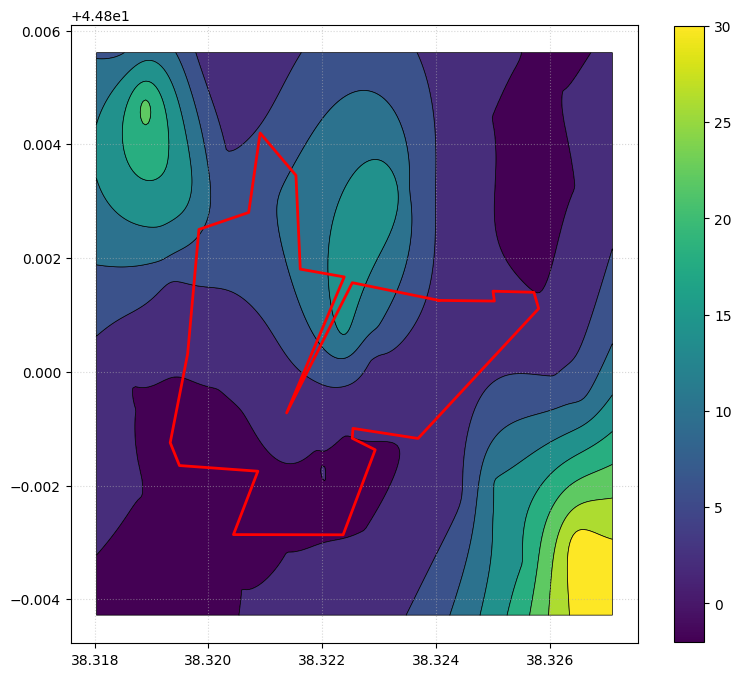

обрезанная по границам карта


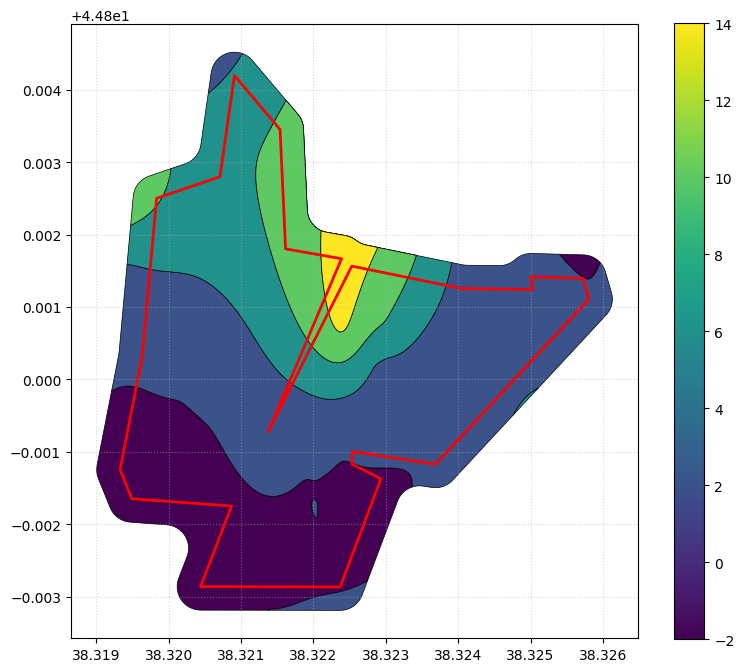

упрощенная обрезанная карта


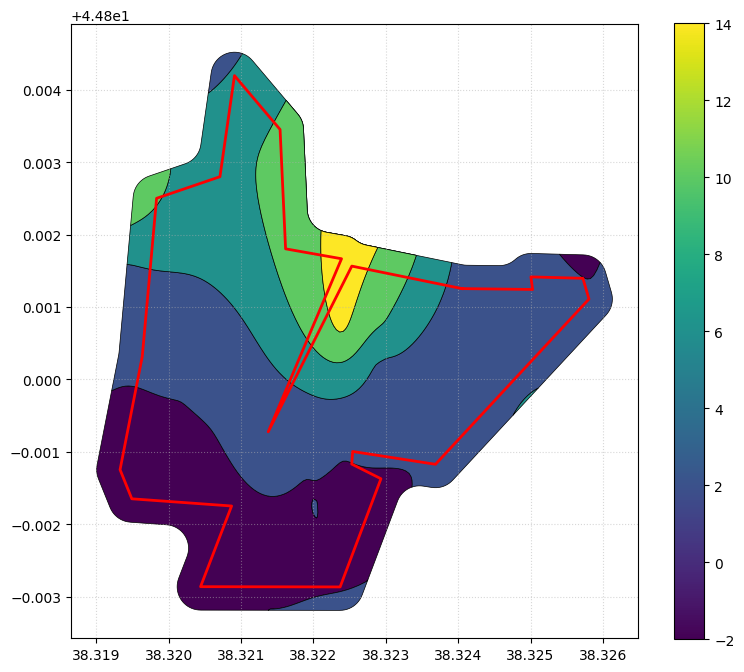

'{\n  "type": "FeatureCollection",\n  "features": [\n    {\n      "type": "Feature",\n      "geometry": {\n        "type": "Polygon",\n        "coordinates": [\n          [\n            [\n              38.322733540808386,\n              44.797211860999376\n            ],\n            [\n              38.32272698023671,\n              44.79720589766191\n            ],\n            [\n              38.32263581514148,\n              44.79716024643557\n            ],\n            [\n              38.32259023259386,\n              44.797140575890815\n            ],\n            [\n              38.32254465004625,\n              44.797122266636364\n            ],\n            [\n              38.322499067498626,\n              44.79710582468666\n            ],\n            [\n              38.32245348495101,\n              44.79709134892781\n            ],\n            [\n              38.3224079024034,\n              44.79707834180174\n            ],\n            [\n              38.322362

In [168]:
def map_calc(
    coordinates: dict,
    values: dict,
    borders=None,
    borders_smooth=True,
    model=RBF(),
    validation=False,
    levels=7,
    rel=1e-6,
    resolution=200,
    coef=100,
    description="Показатель",
    postfix="",
    show=False,
    savejson=False,
    info=False,
):
    """
    Генерирует тематическую карту на основе точечных данных и экспортирует её в формате GeoJSON.

    Функция выполняет полный цикл обработки: пространственную интерполяцию значений,
    построение изолиний, обрезку по границам, упрощение геометрии и экспорт в GeoJSON.
    Поддерживает визуализацию и вывод диагностической информации.

    Args:
        coordinates (dict): Словарь {id: (x, y)} с координатами точек.
        values (dict): Словарь {id: значение} с измеренными или расчётными величинами.
        borders (list or shapely.geometry.Polygon, optional): Границы области интереса
            в виде списка координат [(x1, y1), (x2, y2), ...] или готового полигона.
            Если не задан — используется автоматически определённый прямоугольник.
        borders_smooth (bool, optional): Если True, границы сглаживаются с помощью
            скруглённой буферизации. По умолчанию True.
        model (sklearn-compatible regressor, optional): Модель для интерполяции.
            По умолчанию RBF (радиально-базисная функция).
        validation (bool, optional): Выполнять ли leave-one-out валидацию и расчёт R².
            По умолчанию False.
        levels (int, optional): Количество уровней изолиний. По умолчанию 7.
        rel (float, optional): Относительный допуск для упрощения полигонов
            (относительно размера границ). По умолчанию 1e-6.
        resolution (int, optional): Разрешение интерполяционной сетки. По умолчанию 200.
        coef (float, optional): Коэффициент нормализации высот (используется в prepare_polygon).
            Если 0 — нормализация отключена. По умолчанию 100.
        description (str, optional): Базовое описание для поля "description" в GeoJSON.
            По умолчанию "Показатель".
        postfix (str, optional): Суффикс (например, единица измерения) для описания контуров.
            По умолчанию пустая строка.
        show (bool, optional): Если True — отображает три карты: исходную, обрезанную
            и упрощённую. По умолчанию False.
        savejson (bool, optional): Если True — сохраняет результат в файл `output.geojson`.
            По умолчанию False.
        info (bool, optional): Если True — выводит диагностическую информацию:
            границы, R²-оценку и статистику упрощения полигонов. По умолчанию False.

    Returns:
        str: Строка в формате GeoJSON, представляющая коллекцию полигонов с уровнями,
        описаниями и нормализованными/исходными значениями высот.

    Notes:
        - Ключи в `coordinates` и `values` автоматически синхронизируются через `intersect_dicts`.
        - При `borders_smooth=True` границы обрабатываются функцией `rounded_bounding_box`.
        - Упрощение полигонов использует относительный допуск, вычисляемый по размеру границ.
        - В GeoJSON в поле "description" записывается исходное значение высоты (`z_orig`),
          а в поле "level" — нормализованное (`z_norm`), если `coef != 0`.

    Example:
        >>> coords = {'A': (0, 0), 'B': (5, 5), 'C': (10, 0)}
        >>> vals = {'A': 10, 'B': 20, 'C': 15}
        >>> borders=[[1,1],[1,2],[2,20],[20,20],[10,3]]
        >>> geojson_str = map_calc(coords, vals,borders, show=True, info=True)
    """

    coordinates, values = intersect_dicts(coordinates, values)
    
    if borders != None:
        borders = Polygon(borders)

    x, y, z, borders, r2 = calc_surface(
        values,
        coordinates,
        borders=borders,
        model=model,
        resolution=resolution,
        normalize=True,
        validation=validation,
        gap=20,
    )
    old_borders=copy.copy(list(borders.exterior.coords))
    if borders_smooth:
        borders = rounded_bounding_box(borders, scale_factor=0.1)

    polygons = create_map(x, y, z, levels=levels)

    if borders != None:
        clpolygons = clip_polygons(polygons, borders)
    else:
        clpolygons = polygons

    rel_tolerance = relative_tolerance(borders, rel)
    poly_2d, z_orig, z_norm = prepare_polygon(
        clpolygons, coef=coef, tolerance=rel_tolerance
    )
    geojson = create_geojson_polygons(
        poly_2d, z_orig, z_norm, description=description, postfix=postfix
    )

    if info:
        print("границы области карты")
        print(borders)
        print("R2-score: ", r2)
        print("уменьшение размера полигонов")
        print(compare_vertices(polygons, clpolygons, poly_2d))

    if show:
        print("оригинальная карта")
        plot_polygons(polygons,old_borders)
        print("обрезанная по границам карта")
        plot_polygons(clpolygons,old_borders)
        print("упрощенная обрезанная карта")
        simple_polygon = add_z_to_polygons(poly_2d, z_orig)
        plot_polygons(simple_polygon,old_borders)

    if savejson:
        with open("output.geojson", "w", encoding="utf-8") as f:
            json.dump(geojson, f, ensure_ascii=False, indent=2)

    return json.dumps(geojson, ensure_ascii=False, indent=2)


map_calc(
    coordinates,
    values,
    u,
    borders_smooth=True,
    show=True,
    info=True,
)